In [6]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import pandas as pd
import numpy as np

In [11]:
spike_file = 'spktag/model.pd'

In [12]:
df = pd.read_pickle(spike_file)
df

,frame_id,group_id,fet0,fet1,fet2,fet3,spike_id
0,9.0,5.0,-0.009424,0.027048,-0.065362,0.032897,0.0
1,10.0,7.0,-0.006296,0.002379,-0.066021,0.014112,0.0
2,15.0,25.0,0.982764,0.001183,-0.000121,-0.000263,0.0
3,15.0,24.0,0.982808,0.001015,0.000467,0.001817,0.0
4,15.0,23.0,0.982630,0.001308,-0.000056,-0.000057,0.0
...,...,...,...,...,...,...,...
20977738,12189170.0,22.0,-0.000008,-0.000069,0.000116,0.000015,0.0
20977739,12189171.0,14.0,-0.080070,0.030695,-0.040866,0.024246,0.0
20977740,12189171.0,8.0,-0.177619,-0.076423,0.056426,0.046492,0.0
20977741,12189172.0,19.0,-0.000006,-0.000337,-0.000190,0.000023,0.0


In [28]:
def load_spike(spike_file):
    df = pd.read_pickle(spike_file)
    n_unit = int(df['spike_id'].max())
    spike_time = np.zeros(n_unit, dtype=object)
    spike_fr = np.zeros(n_unit)
    spike_group = np.zeros(n_unit, dtype=int)

    duration = (df['frame_id'].iloc[-1] - df['frame_id'].iloc[0]) / 25000

    for i_unit in range(n_unit):
        in_unit = df['spike_id'] == (i_unit + 1)
        if sum(in_unit) == 0:
            continue
        spike_group[i_unit] = np.unique(df['group_id'][in_unit])[0]
        spike_time[i_unit] = df['frame_id'][in_unit].to_numpy() / 25000
        spike_fr[i_unit] = sum(in_unit) / duration

    return spike_group, spike_time, spike_fr

In [54]:
def plot_spike_firing_rate_and_isi(spike_file, bin_size=1.0):
    _, spike_times, spike_fr = load_spike(spike_file)
    
    n_unit = len(spike_times)
    
    fig, axes = plt.subplots(n_unit, 3, figsize=(15, 5 * n_unit))
    
    for i_unit in range(n_unit):
        spike_time = spike_times[i_unit]
        
        # Plot Firing Rate
        
        axes[i_unit, 0].hist(spike_time, bins=50)
        axes[i_unit, 0].set_title(f"Unit {i_unit+1} - Firing Rate: {spike_fr[i_unit]:.2f} Hz")
        axes[i_unit, 0].set_xlabel("Time (s)")
        axes[i_unit, 0].set_ylabel("Spike Count")
        
        # Plot ISI distribution
        isi = np.diff(spike_time)
        axes[i_unit, 1].hist(isi, bins=50, color='red')
        axes[i_unit, 1].set_title(f"Unit {i_unit+1} - ISI Distribution")
        axes[i_unit, 1].set_xlabel("ISI (s)")
        axes[i_unit, 1].set_ylabel("Count")
        
        # Calculate and plot Firing Rate distribution in 1-second windows
        bin_count, bins = np.histogram(spike_time, np.arange(0, spike_time[-1] + bin_size, bin_size))
        
        # Plot FR distribution
        spike_count, spike_bins = np.histogram(bin_count, 50)
        smoothed_spike_count = gaussian_filter1d(spike_count, sigma=2)
        axes[i_unit, 2].plot(spike_bins[:-1], smoothed_spike_count,color='purple')
        axes[i_unit, 2].set_title(f"Unit {i_unit+1} - FR Distribution (1s windows)")
        axes[i_unit, 2].set_xlabel("Firing Rate (Hz)")
        axes[i_unit, 2].set_ylabel("Count")
        
        # Calculate and plot the 90th percentile line
        fr_90th_percentile = np.percentile(bin_count, 90)
        axes[i_unit, 2].axvline(fr_90th_percentile, color='green', linestyle='dashed', linewidth=1)
        axes[i_unit, 2].text(fr_90th_percentile, axes[i_unit, 2].get_ylim()[1] * 0.9,
                             f' 90th percentile: {fr_90th_percentile:.2f} Hz',
                             color='green', fontsize=12, ha='left')
    
    plt.tight_layout()
    plt.show()

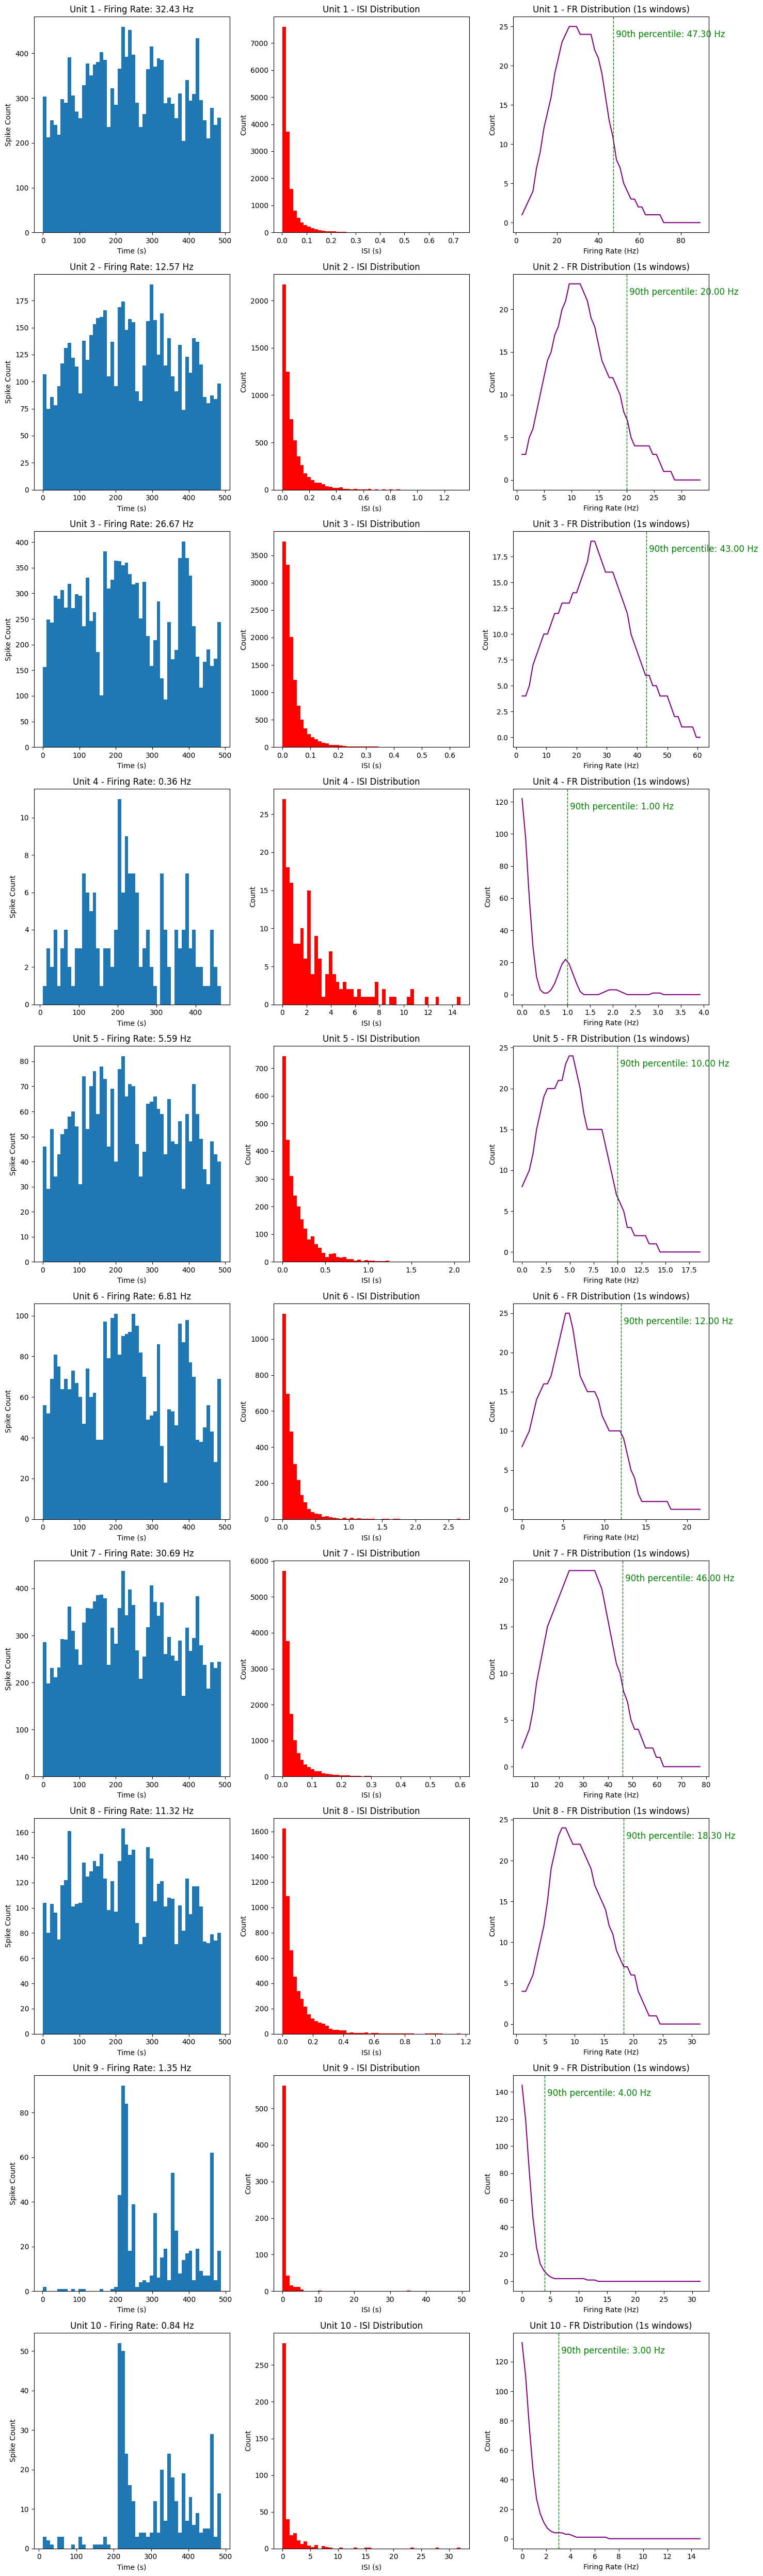

In [55]:
plot_spike_firing_rate_and_isi(spike_file)